In [1]:
# Load Extension for noTeXbook theme
%load_ext notexbook
%texify

# Dataset Partitioning

## Data Partitioning in Machine Learning

To evaluate how well **Supervised** models _generalize_, data are usually _partitioned_ into a _training_ and a _test_ set.

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_test_split.svg)

The *former* is used as the **reference**, and the **only** dataset on which the whole _training process_ of `ML`/`DL` models builds on; whereas the _latter_ is also referred to as the **held-out** dataset, emphasising that this data should be always kept **separate** from the _training data_, 
and only used _afterwards_ to test model *generalisation* capabilities.

On a very similar note, <ins>*training data*</ins> is usually further partitioned into a _validation_ set. This data is used to monitor and validate model's progress during the training, as if it was a 
*development beta version* of a more general test set. In fact, this data is sometimes also referred to as *development set* or <ins>_internal_</ins>[$^{\star}$](#fnstarval) *validation data*.

Therefore, **all** the rules applying to the *test* data, also apply to the *validation* data!

![train_test_split](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/train_validation_test2.svg)

<span id="fnstarval"><i>$^{\star}$: </i> As opposed to **external** validation data used for *test* partition.</span>
<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

⚠️ **Note**

It is worth mentioning that the same principles about data partitions, and their respective roles also applies to any `preprocessing`, and/or derived statistics is derived on the data *before* any actual training is performed. 

For example: **Standardising** a datasets is a common requirement for many machine learning models that might behave badly if the individual features do not more or less look like standard normally distributed data. 

To do so, `sklearn` provides the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) _transformer_ in the [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) package, which standardise each feature by removing the mean ($\mu$), and scaling to unit variance ($\sigma$).

The standard score of a sample $x$ is calculated as:
$$
z = \frac{(x-\mu)}{\sigma}
$$
where $\mu$ and $\sigma$ are respectively the *mean*, and the *standard deviation* of each feature among all the **training** samples!

Therefore:

**1**: <span class="texbook-turquoise">CORRECT</span> ✅

```python 
X_train, X_test = split(X)
scaler = StandardScaler()
scaler.fit(X_train)  # fit on training data ONLY!
...
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

**2**: <span class="texbook-red">**IN**CORRECT</span> ❌

```python 
scaler = StandardScaler()
scaler.fit(X)  # fit on the whole dataset
...
X_train, X_test = split(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
```

In particular, this is <span class="texbook-red">**incorrect**</span> because information from the _training_ set[$^{1}$](#fn1) would leak into the _test_ set, harming the whole principle of using this data to test how well a ML model is able to **generalise** on _unseen_ data. In other words, the _test_ data would not be truly _unseen_ to some extent.
Further examples of `preprocessing` methods as included in `sklearn` can be found in the official [documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py).


<span id="fn1"><i>[1]: </i>Aggregated in the calculation of the $\mu$ and $\sigma$ parameters used for standardisation</span>

Therefore, as a **general rule of thumb**: _always apply data partitioning before anything else_.

To do so, `sklearn` provides an easy to use `train_test_split(*arrays, **options)` helper function, which wraps `(1)` input validation; and `(2)` the use of a more articulate and generic `ShuffleSplit.split` generator, i.e. `next(ShuffleSplit().split(X, y))` 

In this notebook, we will see how we can combine this, and more complex methods for data partitioning with `torch.utils.data.Dataset` objects, and its corresponding `DataLoaders`.

## Split a PyTorch `Dataset`

In order to work our ways into the maze of combining `torch.utils.data.Dataset` with `sklearn.model_selection` methods, let's start by loading our dataset of choice for this tutorial.

In [2]:
from dataset import MTGDataset
from torch.utils.data import DataLoader

In [3]:
# load data partitions
from torchvision.transforms import ToTensor

iceage_cards = MTGDataset(lookup_filters={"set_code": "ice"}, transform=ToTensor())
mirrodin_cards = MTGDataset(lookup_filters={"set_code": "mrd"}, transform=ToTensor())

Loading Full Database file
Cards: 449738 [00:06, 72740.80/s] 

Loading Cards from Database into Oracle
Loading Full Database file
Cards: 449738 [00:06, 69754.79/s] 

Loading Cards from Database into Oracle


In [4]:
len(iceage_cards), len(mirrodin_cards)

(383, 306)

### Combining multiple PyTorch `Dataset`

Our discussion about data partitioning, will incidentally start from the opposite end: _how to combine multiple PyTorch Dataset into one_.

Well, combining multiple `torch` dataset is indeed very easy! Unsurprisingly, it is the **Python Data Model** that comes to the rescue once again!

The `torch.utils.data` package includes a [`ConcatDataset`](https://github.com/pytorch/pytorch/blob/32b4b51254dce410484cfc68052729227505ee24/torch/utils/data/dataset.py#L177) class which is specifically designed to _chain_ multiple dataset. Moreover, the `torch.utils.data.Dataset` class [implements](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/dataset.py#L35) the `__add__` [method](https://docs.python.org/3/reference/datamodel.html#object.__add__) which clearly defines the expected behaviour when **two** `Dataset` instances are summed together:

In [5]:
type(iceage_cards + mirrodin_cards)

torch.utils.data.dataset.ConcatDataset

**Therefore**, let's start by joining together the three pre-defined `FER` partitions

In [6]:
mtg_dataset = iceage_cards + mirrodin_cards

In [7]:
len(mtg_dataset), len(mtg_dataset) == sum(map(len, (iceage_cards, mirrodin_cards)))

(689, True)

### Set Determinism

Before proceeding any further, let's just allow for some _determinism_ and _future reproducibility_!

We will set the random seeds in both `Numpy` and `PyTorch` to ensure that generated data partitions will be exactly the same, everytime this notebook will be executed! 

On a more general note, **randomness** in a Machine Learning workflow appears in many steps:

1. *Data Preparation* (e.g. `pandas.sample` in our example?)
2. *Data Preprocessing* (e.g. `RandomApply` for our transformers?)
3. *Data Partitioning and Cross Validation* (**this notebook**)
4. *Model Weights Initialisation*
5. ...

All these factors can contribute to variations across runs, harming the reproducibility and/or replicability of the whole pipeline. Moreover, this is why it is always a good idea to be able to control the multiple source of randomness, _without_ necessarily relying on the *global* seed.

The **random seed** is a starting point for the sequence, and the guarantee is that if you start from the same seed you will get the same sequence of numbers. And so, you **also want to test your models with multiple seed values**!


In [8]:
import torch
import numpy as np

SEED = 189212  # 0b101110001100011100

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**Further reading**: [PyTorch Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html)

### Train-Test Split

Let's finally workout our first solution to partition a `torch.Dataset`!


First mention goes to the `built-in` method in `torch.utils.data` to [`random_split`](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#random_split) a `Dataset` into a list of `Subset` instances.

A `torch.utils.data.Subset` is a very simple class which combines together a `Dataset` and a `Sequence[int]` of indices to access its elements.

The `random_split` function expects a `dataset`, a list of `lengths`, and a `torch.Generator` instance (if any) to control the random permutations of indices, when creating the `Subset`.

So, to easily re-create the three `FER` partitions using the `random_split` function:

In [9]:
from torch.utils.data import random_split

In [10]:
mtg_train, mtg_valid, mtg_test = random_split(mtg_dataset, lengths=(441, 110, 138), 
                                              generator=torch.Generator().manual_seed(920))

In [11]:
type(mtg_train), type(mtg_valid), type(mtg_test)

(torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

In [12]:
list(map(len, (mtg_train, mtg_valid, mtg_test)))  # lengths

[441, 110, 138]

This worked as expected, however: 
1. specifying the actual number of samples per dataset is not very practical;
2. we could not apply any `stratification` to guide the selection.


Similarly, we could implement our own version of `random_split` which is slightly different and leverages on [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split).

The only thing to keep in mind, is that `train_test_split` generates two partitions at a time, therefore, we should `train-test` split first, and `train-validation` split, afterword.

In [13]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split


def train_test_dataset_split(dataset, test_size=.25, validation_size=.25,
                             random_state=None, shuffle=True, with_stratification=False):
    
    if with_stratification:
        stratify = np.asarray([setcode for _, setcode in iter(dataset)])
    else:
        stratify = None
        
    train_indices, test_indices = train_test_split(np.arange(len(dataset)), 
                                                   test_size=test_size, shuffle=shuffle,
                                                   random_state=random_state,
                                                   stratify=stratify)
    test_subset = Subset(dataset, test_indices)
    train_subset = Subset(dataset, train_indices)
    if with_stratification:
        # update labels
        stratify = np.asarray([setcode for _, setcode in iter(train_subset)])
    
    train_indices, valid_indices = train_test_split(train_indices, test_size=validation_size, 
                                                    shuffle=shuffle, random_state=random_state,
                                                    stratify=stratify)
    train_subset = Subset(dataset, train_indices)
    valid_subset = Subset(dataset, valid_indices)
    return [train_subset, valid_subset, test_subset]
    

In [14]:
mtg_train, mtg_valid, mtg_test = train_test_dataset_split(mtg_dataset, test_size=.10, 
                                                          validation_size=.11,
                                                          with_stratification=True)

In [15]:
type(mtg_train), type(mtg_valid), type(mtg_test)

(torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset,
 torch.utils.data.dataset.Subset)

In [16]:
list(map(len, (mtg_train, mtg_valid, mtg_test)))  # lengths

[551, 69, 69]

**Exercise**

As an exercise, please plot class distributions after stratification

In [17]:
#your code here

---

### Cross Validation

By partitioning the available data into three sets (i.e. _train_, _validation_, _test_), we 
drastically reduce the number of samples which are using for learning the model, 
and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this issue is a procedure called **Cross Validation** (`CV` in short).

(from [Wikipedia](https://en.wikipedia.org/wiki/Cross-validation_(statistics)))

> Cross-validation, sometimes called **rotation estimation**, or *out-of-sample testing*, 
> is (*a*) model validation technique for assessing how the results 
> of a statistical analysis will generalize to an independent data set.
> [$\ldots$]
> The **goal** of cross-validation is to test the model's ability 
> to predict new data that was not used in estimating it, in order to **flag problems** like 
> <ins>overfitting or selection bias</ins>.



#### How does `CV` works?

A **test set** is still **held out** for <ins>final evaluation</ins>, but the *validation set* is no longer intended as a single partition, in the `CV` strategy. 

In the most general settings, (i.e. `k-fold CV`), the _training set_ is split into **k smaller sets**, so that:

1. Select $k-1$ folds for training, $1$ fold for validation;
2. A model is **trained** using the selected $k - 1$ folds of the data;
3. the model is **validated** on the remaining $k_{th}$ fold kept out.
4. Repeat this process again (**<ins>re-initialising all model parameters</ins>**) by applying a different selection to the folds for training/validation **until** all the folds has been used once for validation.

5. Aggregate results for each data partitioning, and derive statistics (with confidence intervals) on model predictions and generalisation capabilities.

##### K-Fold Cross Validation Partitions

![cross_validation](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/4_data_partitioning/imgs/cross_validation.svg)

<span class="fn"><i>Source: </i> [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) _from_ **scikit-learn** documentation.</span>

There exist multiple strategies (or variations) on how folds can be generated during a `CV`, and the [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) package provides classes and functions to handle different partitioning strategies, and data configurations. 

Among the many brilliant examples provided in `sklearn` documentation, I would strongly recommend 
[Visualizing cross-validation behaviour in scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html), which practically shows the effect of different data selection strategies when creating folds.

#### KFold and torch.Dataset

Now, let's see how we can **re-use** the `sklearn.model_selection.KFold` class with a `torch.Dataset`.

All the **Splitter** classes in `sklearn.model_selection` share the *same* API (as it is customary in `sklearn`, _ed._):

```python 
>>> from sklearn.model_selection import KFold
>>> KFold(n_splits: int,           # how many partitions to generate
          shuffle: bool = False    # whether applying data shuffling beforehand
          random_state: int or RNG # Crucial! Parameter to control randomness
         )
>>> kfold = KFold(n_splits=5, random_state=SEED)
>>> for train_indices, valid_indices in kfold.split(X)
...     X_train, X_val = X[train_indices], X[val_indices]
...
```

Now, `X` is supposed to be an _array-like_ object, usually a `numpy.ndarray`.

However, a `torch.Dataset` is indeed a **subscriptable** objects, so we can use is as an input parameter!

In [18]:
from sklearn.model_selection import KFold

In [19]:
kfold = KFold(n_splits=2, random_state=12345, shuffle=True)
for train_idx, test_idx in kfold.split(mtg_dataset):
    print(train_idx, test_idx)

[  1   5   7   8  12  13  14  15  16  21  23  26  29  30  32  34  36  37
  38  39  42  43  44  45  47  49  50  51  53  58  59  60  61  63  64  69
  71  72  73  76  77  78  79  80  81  82  83  86  88  91  92  94  95  96
  98 102 105 107 108 113 114 116 118 121 122 124 125 126 127 128 129 131
 132 137 140 141 142 143 145 146 149 151 155 161 165 166 167 170 171 172
 173 174 176 182 185 189 200 201 205 208 209 210 211 212 214 215 217 218
 219 222 224 225 226 227 228 229 230 231 232 235 236 237 242 243 245 246
 247 248 249 251 252 256 259 260 261 262 263 264 265 267 269 271 272 273
 274 278 279 282 285 287 288 290 293 294 295 297 301 302 307 309 312 313
 315 316 318 319 320 321 323 325 326 327 331 333 336 337 338 339 340 344
 345 347 349 352 353 354 357 358 360 362 366 368 369 371 372 374 376 378
 379 382 383 387 389 392 393 396 397 398 400 401 402 405 406 407 408 409
 410 412 414 415 418 419 420 423 425 427 430 431 432 433 435 437 438 439
 440 441 443 444 448 454 456 458 459 461 464 466 47

In [20]:
type(mtg_dataset)

torch.utils.data.dataset.ConcatDataset

##### Changing Data Loading strategy, not dataset

Alternatively, we can implement a very simple `Sampler` object, `FoldSampler`:

In [21]:
from torch.utils.data import Sampler
from typing import Sequence


class FoldSampler(Sampler[int]):
    r"""Samples elements from a given list of indices.

    Arguments:
        indices (sequence): a sequence of indices
    """
    indices: Sequence[int]

    def __init__(self, indices: Sequence[int]) -> None:
        self.indices = indices

    def __iter__(self):
        return (i for i in self.indices)

    def __len__(self):
        return len(self.indices)

Simple as that! Incidentally, whereas `torch.utils.data` includes an implementation of a `SequentialSampler`, and a `SubsetRandomSampler`, it does not exist a `SubsetSampler` (I guess mainly because it is really trivial to implement! 🙃

In [31]:
training_folder_loader = DataLoader(mtg_dataset, sampler=FoldSampler(train_idx),
                                    batch_size=10)

validation_folder_loader = DataLoader(mtg_dataset, sampler=FoldSampler(test_idx),
                                      batch_size=10)

In [32]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

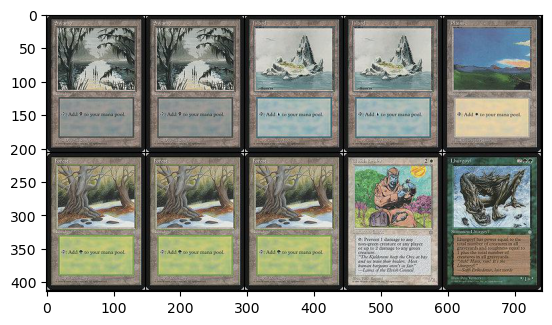

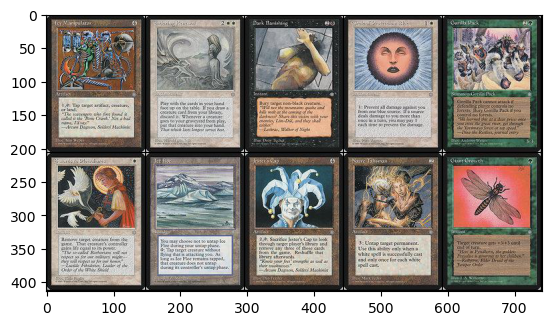

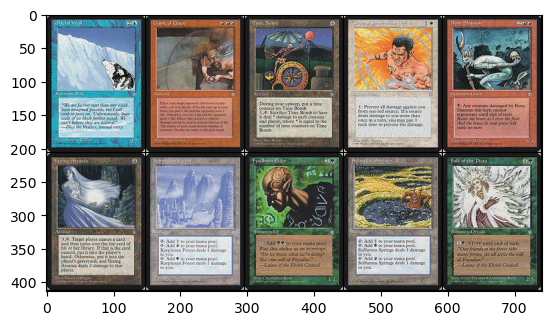

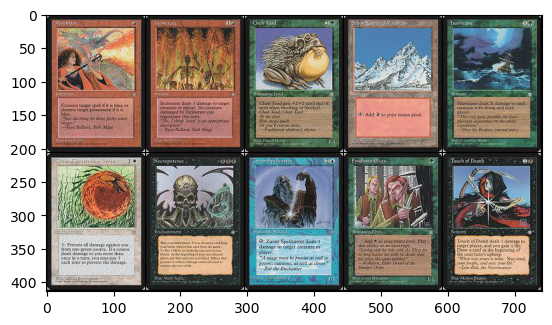

In [33]:
for i, batch in enumerate(training_folder_loader):
    grid = make_grid(batch[0], nrow=5)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break

[0 2 3 4 6]


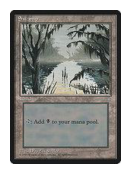

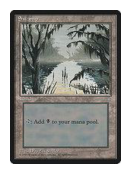

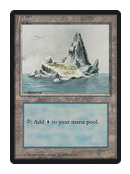

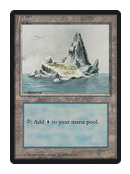

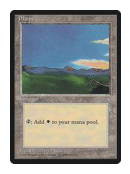

In [34]:
#double check for the first row of images
train_idx[:5]
print(train_idx[:5])
for idx in train_idx[:5]:
    plt.figure(figsize=(2, 2))
    plt.imshow(mtg_dataset[idx][0].numpy().transpose(1, 2, 0), 
               interpolation="bilinear", cmap="gray")
    plt.axis("off")
    plt.show()


#### Caveat

There is a caveat with this approach: if you would pass in a `sampler` to a `DataLoader`, it won't be possible to use `shuffle=True` for batches in training.

However, that could be easily resolved by substituting the custom `FoldSampler` with the built-in `SubsetRandomSampler` and indices will be **permuted** every epoch automatically as it would happen with the `shuffle` parameter.

---